In [9]:
import numpy as np
import cv2
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

Method is executed only for first frame, because edges positions are fixed.
First we use Canny edge detector to detect edges in a frame.

The process of Canny edge detection algorithm can be broken down to five different steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise

2. Find the intensity gradients of the image

3. Apply gradient magnitude thresholding or lower bound cut-off suppression to get rid of spurious response to edge detection

4. Apply double threshold to determine potential edges

5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.[source](https://en.wikipedia.org/wiki/Canny_edge_detector)

eg. for video1.mp4 output looks like this:

<img src="images/canny_edge.jpg">

After this we use HoughLinesP method to get lines from edges. In this case we are looking for lines that are longer than 385.

This method finds line segments in a binary image using the probabilistic Hough transform.

The basic idea of Hough transform (HT) is to implement a voting procedure for all potential curves in the image, and at the termination of the algorithm, curves that do exist in the image will have relatively high voting scores. Randomized Hough transform (RHT) is different from HT in that it tries to avoid conducting the computationally expensive voting process for every nonzero pixel in the image by taking advantage of the geometric properties of analytical curves, and thus improve the time efficiency and reduce the storage requirement of the original algorithm.[source](https://en.wikipedia.org/wiki/Randomized_Hough_transform)

Once we have our lines, we can pinpoint the edges by getting vertical line with lowest X value for left edge, and vertical line with highest X value for right edge.

To visualize output we can use cv2.line to draw lines we marked as edges.

Output for video1.mp4:
<img src="images/edges_hough.jpg">

Note that right edge is elevated, because of the rectangle in bottom part of the edge.
This will not effect the program since ball cannot hit that part of the edge anyway.

In [10]:
def get_left_and_right_edge(frame):
    edges = cv2.Canny(frame, 100, 200) #CannyEdge

    lines = cv2.HoughLinesP(image=edges, rho=1, theta=np.pi / 180, threshold=10, lines=np.array([]),
                            minLineLength=385, maxLineGap=20)  #Extract lines from edges

    #Initial value for edges
    left_edge = [960, 0, 960, 0]  
    right_edge = [0, 0, 0, 0]
    if lines is not None:
        for i in range(0, len(lines)):
            line = lines[i][0]
            (x1, y1), (x2, y2) = (line[0], line[1]), (line[2], line[3])
    
            if x1 == x2:  # condition for vertical line
                if x1 < left_edge[0]:
                    left_edge = [x1, y1, x2, y2]  # vertical line with minimum X value is left edge
                if x1 > right_edge[0]:
                    right_edge = [x1, y1, x2, y2] # vertical line with maximum X value is right edge
    
    #Mark edges on frame
    cv2.line(frame, (left_edge[0], left_edge[1]), (left_edge[2], left_edge[3]), (0, 0, 255), 3, cv2.LINE_AA)
    cv2.line(frame, (right_edge[0], right_edge[1]), (right_edge[2], right_edge[3]), (0, 0, 255), 3, cv2.LINE_AA)

    return left_edge, right_edge

For each frame we get balls positions.

First we convert frame to colorless image.
Then we apply threshold to gray image to get binary image.
After that, we use cv2.findContours to isolate objects from background.
Now we need to extract balls from there contours we just obtained.
Since balls dimension is fixed, we can filter the list of contours and get only balls, by using method minEnclosingCircle.
This method will return center coordinates of the ball and its radius.
We save center coordinates to later check whether ball hit the edge or not.

In [11]:
def get_balls(frame):
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    ret, image_bin = cv2.threshold(frame_gray, 150, 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(image_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    countours_balls = []
    for contour in contours:
        (x, y), r = cv2.minEnclosingCircle(contour) # (x, y) are center coordinates r is radius
        if 4 > r > 3.5:  # condition to see if contour is actually a ball
            countours_balls.append((x, y))
    return countours_balls

After extraction of balls positions, we need to check if ball hit the edge.
We do that by comparing X coordinate of ball center with X coordinate of edge.

In [12]:
def check_for_contact(left_edge, right_edge, balls):
    left_edge_x = left_edge[0]
    right_edge_x = right_edge[0]
    for ball in balls:  # for each ball in frame we are checking if its X value is close enough to edge to consider it a hit
        x = ball[0]
        if x - left_edge_x <= 20:
            return True
        if right_edge_x - x <= 20:
            return True

Method that iterates through every frame of the video and returns actual count of hits.

In order to avoid having one hit recognised as more, we avoid counting hit if it happened within two frames from previous hit.
We do this because ball travels different distance with each frame, sometimes it will capture the frame where ball is in direct hit with the edge, and in next frame it will still be close to the edge, so it will count it as two hits. With this we eliminate possibility of that happening.

If you want to see the frames where ball hits the edge (and results for each video), please run SOFT3.py script.

In [13]:
def process_video(video_path):
    frame_num = 0
    cap = cv2.VideoCapture(video_path)
    cap.set(1, frame_num)  # indexing frames

    left_edge, right_edge = [], []
    hit_counter = 0
    # analyze video frame by frame
    previous_hit = -1 # variable that is used to avoid counting 1 hit as more(successive frames may be considered hits multiple times)
    
    while True:
        frame_num += 1
        ret_val, frame = cap.read()

        if not ret_val:
            break
            
        if frame_num == 1:  # for first frame get left and right edge
            left_edge, right_edge = get_left_and_right_edge(frame)

        balls = get_balls(frame)

        hit = check_for_contact(left_edge, right_edge, balls)
        
        if hit and frame_num > previous_hit + 2:
            hit_counter += 1
            previous_hit = frame_num

    return hit_counter

For each video we need to check how many hits actually happened. That information is in data/res.txt

In [14]:
def get_real_count_for_video(file_name, video_name):
    file_lbl = open(file_name, "r")
    for line in file_lbl.readlines():
        tokens = line.strip().split(",")
        if tokens[0] == video_name:
            return int(tokens[1])

This piece of code shows how we calculate MAE. 

Mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. MAE is calculated as:

MAE = sum(|yi - xi|) / n

Where yi is the prediction, xi is true value and n is dataset size. [source](https://en.wikipedia.org/wiki/Mean_absolute_error)

First we load all videos from data folder.
Then we run process_video which returns predicted amount of hits, and we read true amount of hits from res.txt.
After that, we use mean_absolute_error method from module sklearn.

With this dataset we get MAE = 0.3

MAE: 0.3


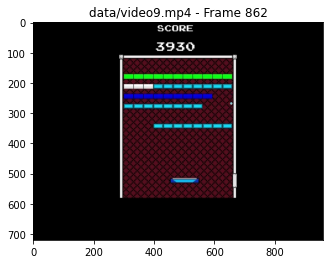

In [18]:
root_path = "data"

dataset = []

for file in os.listdir(root_path):
    filename = os.fsdecode(file)
    if filename.endswith(".mp4"):  # get every video from data folder and add it to dataset
        dataset.append(file)

# lists of real and predicted values to use for calculating mean absolute error
y_true = []
y_pred = []

for video in dataset:
    bounces = process_video(root_path + "/" + video) # get predicted value
    real = get_real_count_for_video(root_path + "/res.txt", video) # get real value
    y_true.append(real)
    y_pred.append(bounces)
    
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")